In [94]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from scipy.linalg import expm
from scipy.linalg import null_space

from general_graph_utils import *

In [95]:
def affinity(k12,k21,k23,k32,k31,k13):
    aff = np.log((k12*k23*k31)/(k13*k32*k21))
    return aff

In [96]:
# Transition rate matrix W
def transition_matrix(k12,k21,k23,k32,k31,k13):
    W = np.array([
        [-k12 - k13, k21, k31],  # Transition rates from E1
        [k12, -k21 - k23, k32],  # Transition rates from E2
        [k13, k23, -k31 - k32],  # Transition rates from E3
    ])
    return W

In [100]:
# Function to compute the correlation function C(t)
def correlation_function(t, W):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    p = [1,0,0]
    return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0

All rates = 1.0

In [144]:
k12, k21 = 1.0, 1.0  # Rates between E1 and E2
k23, k32 = 1.0, 1.0  # Rates between E2 and E3
k31, k13 = 1.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

0.0
[-3.0000000e+00+0.j  4.4408921e-16+0.j -3.0000000e+00+0.j]
decay time: 2251799813685248.0
period: inf
number coherent oscillations: 0.0


/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_70677/1431143035.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  omega = (2*math.pi)/x_i


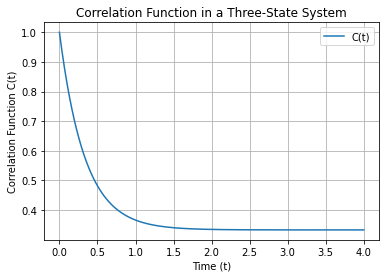

In [115]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

$\mathcal{A}$ = 1.0

In [136]:
k12, k21 = 1.0, 2.0  # Rates between E1 and E2
k23, k32 = 1.5, 1.0  # Rates between E2 and E3
k31, k13 = 2.0, 0.5  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

1.0986122886681098
[ 4.4408921e-16+0.j -3.5000000e+00+0.j -4.5000000e+00+0.j]
-0.2857142857142857
inf
-0.0


/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_70677/41815920.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  omega = (2*math.pi)/x_i


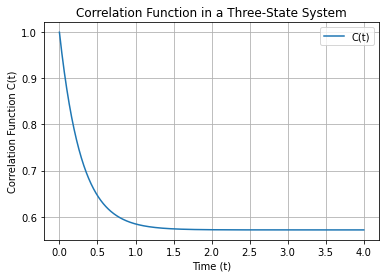

In [117]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Oscillatory transition rates

In [141]:
# Oscillatory transition rates
k12, k21 = 1.0, 0.5  # Rates between E1 and E2
k23, k32 = 1.5, 0.2  # Rates between E2 and E3
k31, k13 = 2.0, 0.1  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

5.703782474656201
[-3.18595413e-16+0.j         -2.65000000e+00+0.99874922j
 -2.65000000e+00-0.99874922j]
decay time: -0.3773584905660376
period: 6.291054045776005
number coherent oscillations: -0.5920119255341094


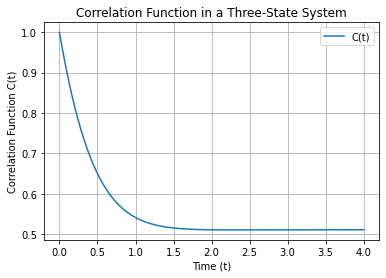

In [119]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Eigenvalues complex

In [143]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 0.10536, 0.00158, 0.00805, 0.06794, 0.03089, 0.08335

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 50, 500)  # time from 0 to 50 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: -7.325527183964429
eigenvalues: [-1.48585000e-01+0.05398063j -1.48585000e-01-0.05398063j
  2.38637456e-17+0.j        ]
decay time: -6.730154457044786
period: -116.39703431960048
number coherent oscillations: 0.5706671345841586


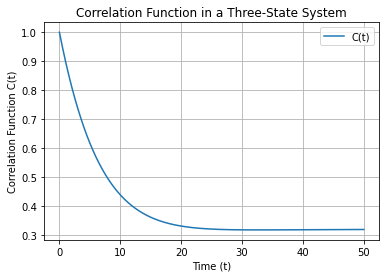

In [125]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

In [145]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 1.160000e-03, 1.330766e+01, 8.319220e+00, 3.330000e-03, 1.046221e+01, 1.978970e+00

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1.5, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 18.836219768636184
eigenvalues: [ 3.58090794e-15+0.j         -1.70362750e+01+8.55151942j
 -1.70362750e+01-8.55151942j]
decay time: 0.058698277645788215
period: 0.734744903218277
number coherent oscillations: 0.7884760776858771


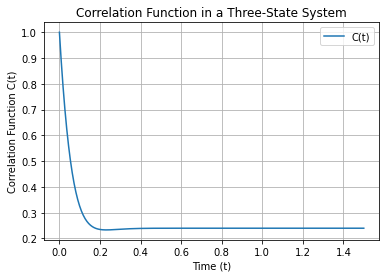

In [127]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Totally away from equilibrium (unidirectional)

In [147]:
# Oscillatory transition rates
k12, k21 = 2.0, 0  # Rates between E1 and E2
k23, k32 = 2.0, 0  # Rates between E2 and E3
k31, k13 = 2.0, 0  # Rates between E3 and E1

# force
#print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

eigenvalues: [-3.00000000e+00+1.73205081j -3.00000000e+00-1.73205081j
 -6.48686449e-17+0.j        ]
decay time: 0.3333333333333333
period: 3.627598728468435
number coherent oscillations: 0.906899682117109


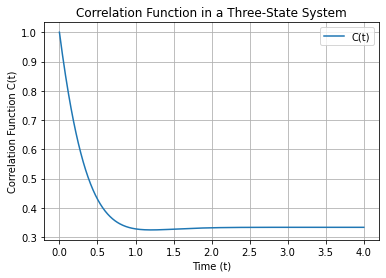

In [131]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

In [151]:
# Oscillatory transition rates
k12, k21 = 20.0, 1.0  # Rates between E1 and E2
k23, k32 = 20.0, 1.0  # Rates between E2 and E3
k31, k13 = 20.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1, 500)  # time from 0 to 1 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 8.987196820661973
eigenvalues: [-3.49536271e-15 +0.j         -3.15000000e+01+16.45448267j
 -3.15000000e+01-16.45448267j]
decay time: 0.03174603174603172
period: 0.3818524977335192
number coherent oscillations: 0.8205282838202415


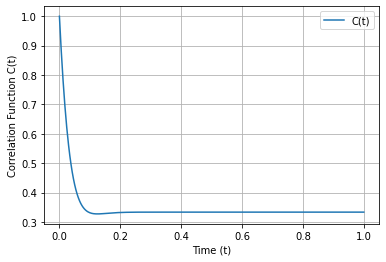

In [152]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
#plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

What parameter sets give you complex eigenvalues?

In [19]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

In [20]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [21]:
label_dict, label_list = get_labels(G)

In [22]:
label_dict

{(1, 3): 205.59491,
 (1, 2): 395.3394,
 (2, 3): 8.32158,
 (2, 1): 0.25334,
 (3, 1): 0.19346,
 (3, 2): 0.00396}

In [23]:
all_labels = np.zeros((1000,6))
all_eigvals_real = np.zeros((1000,3))
all_eigvals_complex = np.zeros((1000,3))
all_affinities = np.zeros((1000,1))

In [24]:
for i in range(1000):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

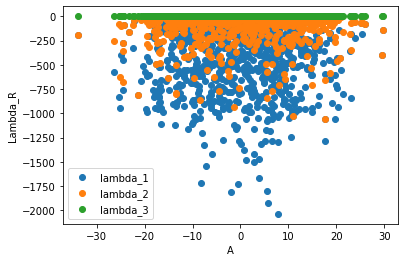

In [25]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

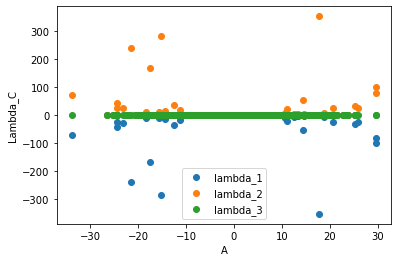

In [26]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [27]:
np.nonzero(all_eigvals_complex)

(array([ 12,  12,  13,  13,  98,  98, 173, 173, 231, 231, 276, 276, 281,
        281, 398, 398, 403, 403, 474, 474, 492, 492, 517, 517, 518, 518,
        547, 547, 573, 573, 593, 593, 610, 610, 640, 640, 679, 679, 730,
        730, 875, 875, 877, 877, 897, 897, 899, 899, 912, 912, 964, 964,
        990, 990]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

In [29]:
all_affinities[12]

array([18.83621977])

In [31]:
all_eigvals_complex[12]

array([-8.21559947,  8.21559947,  0.        ])

In [32]:
all_labels[12,:]

array([1.160000e-03, 1.330766e+01, 8.319220e+00, 3.330000e-03,
       1.046221e+01, 1.978970e+00])

In [33]:
label_dict

{(1, 3): 0.85838,
 (1, 2): 2.81255,
 (2, 3): 23.04062,
 (2, 1): 0.01257,
 (3, 1): 0.06076,
 (3, 2): 0.82315}

More formal workflow

In [57]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3, weight = k_1m)
G.add_edge(3,1, weight = k_3p)
G.add_edge(2,3, weight = k_2p)
G.add_edge(3,2, weight = k_3m)
G.add_edge(1,2, weight = k_1p)
G.add_edge(2,1, weight = k_2m)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

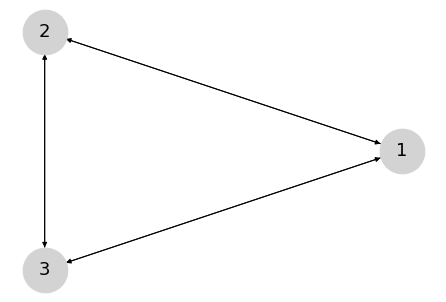

In [58]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

Next, we calculate some data structures encoding information about the graph.

In [59]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [60]:
label_dict, label_list = get_labels(G)

In [61]:
label_dict

{(1, 3): 1.0,
 (1, 2): 4.607186634331275e+28,
 (2, 3): 4.607186634331275e+28,
 (2, 1): 1.0,
 (3, 1): 4.607186634331275e+28,
 (3, 2): 1.0}

In [62]:
label_list

array([1.00000000e+00, 4.60718663e+28, 4.60718663e+28, 1.00000000e+00,
       4.60718663e+28, 1.00000000e+00])

Then, we calculate the cycle affinity using the general graphs framework (overkill for the 3-vertex graph, but it works).

In [63]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [64]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[198.]


For fun, we can calculate the steady state distribution using the spectrum of the Laplacian.

In [65]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [66]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

Let's grab the eigenvalues and eigenvectors of the Laplacian matrix.

In [39]:
eigvals, eigvecs = scipy.linalg.eig(L)

In [40]:
eigvals

array([-6.91077995e+28+3.98994067e+28j, -6.91077995e+28-3.98994067e+28j,
       -6.55378477e+12+0.00000000e+00j])

In [41]:
eigvecs

array([[-0.28867513+0.5j, -0.28867513-0.5j, -0.57735027+0.j ],
       [-0.28867513-0.5j, -0.28867513+0.5j, -0.57735027+0.j ],
       [ 0.57735027+0.j ,  0.57735027-0.j , -0.57735027+0.j ]])

Calculate the correlation function $C_{1,1}(t)$

In [42]:
t = np.around(np.arange(100.0,250.0,step=.01), decimals = 2)

In [43]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

/Users/sabinahaque/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/matfuncs.py:437: RuntimeWarning: overflow encountered in longdouble_scalars
  self._d10_exact = _onenorm(self.A10)**(1/10.)


In [44]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

In [45]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_8972/908813237.py:8: RuntimeWarning: invalid value encountered in multiply
  new_list[i] = ((list_result[i]*P_0)[0])[0]


In [46]:
new_list[0]

array([inf, inf, inf])

In [47]:
((L*P_0)[:,0])

array([-4.60718663e+28,  1.00000000e+00,  4.60718663e+28], dtype=float128)

Text(0, 0.5, 'C_1,1(t)')

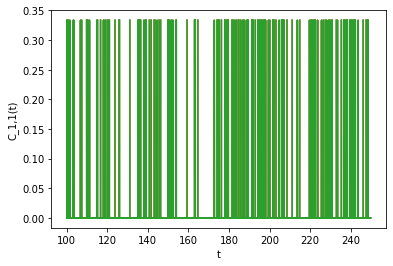

In [50]:
plt.plot(t, new_list)
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()